**set up**

In [ ]:
# install Hugging face transformers library and dataset
! pip install transformers datasets evaluate accelerate

# install package to evaluate an automatic speech recognition system
! pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.0 MB/s eta 0:00:00


In [ ]:
# import transformers package
import transformers

**load a dataset**

In [ ]:
from datasets import load_dataset

#dataset = load_dataset("Rizqi/emotion-raw")
dataset = load_dataset("dair-ai/emotion")
dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Emotion', 'Text'],
        num_rows: 34792
    })
})

In [ ]:
# Split the dataset’s train split into a train and test set
# with the [~datasets.Dataset.train_test_split] :

dataset = dataset["train"].train_test_split(test_size=0.1)
train_ds = dataset["train"]
test_ds = dataset["test"]

**preprocessing**

In [ ]:
# load the processor class associated with the model you are about to fine-tune
from transformers import AutoProcessor

checkpoint = "aiknowyou/it-emotion-analyzer" #기존 모델 위치(pre-train)
processor = AutoProcessor.from_pretrained(checkpoint) #기존 모델이 지닌 전처리 도구를 합친 후 load

processor: 토크나이저의 일종으로 입력을 숫자로 변경

같은 인수를 사용하면 함께 사용 불가, 각기 토크나이저 지정

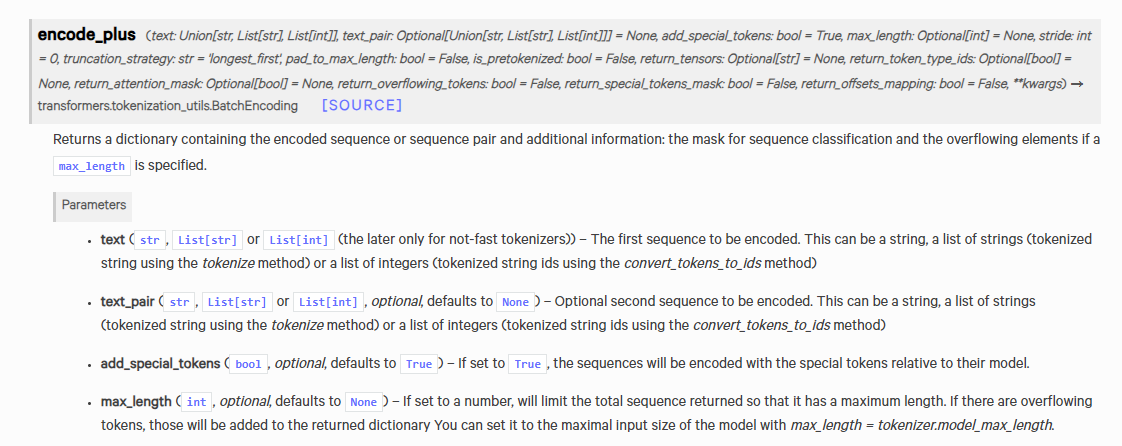

In [ ]:
# Internally pre-process the image (which includes resizing, and pixel scaling) and tokenize the caption.
def transforms(example_batch):
    #texts = [x for x in example_batch["text"]] #사용할 columns 명, dataset에서 가져오기
    #emotions = [str(x) for x in example_batch["label"]]
    texts = [x for x in example_batch["Text"]] #사용할 columns 명, dataset에서 가져오기
    emotions = [x for x in example_batch["Emotion"]]
    #inputs = processor(images=images, text=captions, padding="max_length") #from_pretrained로 가져오는 processor에 따라 input 변화
    inputs = processor(text=texts, text_pair=emotions, padding="max_length") #분류를 위해 encoding하는 경우, 일반적으로 별도로 encoding해야 한다.
    inputs.update({"labels": inputs["input_ids"]})
    return inputs

train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

**load a base model**

In [ ]:
from transformers import AutoModelForSequenceClassification

# Load the checkpoint into a AutoModelForSequenceClassification object
#model = AutoModelForCausalLM.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint) #사용 목적이 바뀌었으니 다른 model 필요(인과적 언어 모델->text 분류)

**evaluation**

In [ ]:
from evaluate import load
import torch

# Image captioning models are typically evaluated with the Rouge Score or Word Error Rate
# In this example, we will use the Word Error Rate (WER)
wer = load("wer")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

**train a model**

In [ ]:
#define the training arguments using TrainingArguments
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = "./emotion", #저장 위치, ./ 형태로 설정하면 미리 만들 필요 X
    learning_rate=5e-3, #running rate
    num_train_epochs=50, #epoch 횟수
    fp16=True, #True when using GPU
    per_device_train_batch_size=512, #train 과정의 batch size
    per_device_eval_batch_size=512, #evlauation 과정의 batch size
    gradient_accumulation_steps=2, #back propagation 과정에서 누적되는 step 수
    save_total_limit=3, #checkpoint의 최대 개수
    evaluation_strategy="steps", #step 종료마다 evaluation, 추가 단위로 no와 epoch 존재
    eval_steps=50, #각 evaluation 사이의 step
    save_strategy="steps",
    save_steps=50,
    logging_steps=50, #log 사이의 step
    remove_unused_columns=False, #사용하지 않는 columns 자동 삭제
    push_to_hub=True, #model이 저장될 때마다 hub에 update
    label_names=["labels"],
    load_best_model_at_end=True,
)

In [ ]:
# Login to your Hugging Face account to get token
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
# Pass the training arguments along with the datasets and the model to Hugging face Trainer.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)

/content/./emotion is already a clone of https://huggingface.co/AIove/emotion. Make sure you pull the latest changes with `repo.git_pull()`.


In [ ]:
# start training
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


OutOfMemoryError: ignored

**test**

In [ ]:
# Take a sample image
from PIL import Image
import requests

sentences = ["Questa è una frase triste", "Questa è una frase felice", "Questa è una frase di stupore"]

In [ ]:
# Prepare image for the model.
device = "cuda" if torch.cuda.is_available() else "cpu"

inputs = processor(text=sentences, return_tensors="pt").to(device)

In [ ]:
# Call generate and decode the predictions.
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)
# -> needs more tuning

NameError: ignored